In [1]:
import json
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from sklearn import linear_model, metrics, decomposition
import pprint
%matplotlib inline

In [2]:
df = pd.read_csv('cleaned_data.csv', index_col='Respondent')
with open('column_mapping.json', 'r') as f:
    column_mapping = json.load(f)

In [3]:
row_drop_mask = ((df['YearsProgram'].isnull() & df['YearsCodedJob'].isnull()) |
                 (df['CareerSatisfaction'].isnull()) |
                 (df['JobSatisfaction'].isnull()) |
                 (df['YearsCodedJobPast'].notnull()))
rows_to_drop = df[row_drop_mask].index
df.drop(index=rows_to_drop, inplace=True)

In [4]:
cols_to_drop = []
for col in df.columns:
    if not col.startswith('Country_'):
        continue
    num_from_country = df[col].sum()
    if num_from_country < 10:
        cols_to_drop.append(col)

cols_to_drop += ['ExpectedSalary', 'StackOverflowSatisfaction', 'HoursPerWeek', 'YearsCodedJobPast']
df.drop(columns=cols_to_drop, inplace=True)

In [5]:
rows_with_no_YearsProgram = df[df['YearsProgram'].isnull()].index
df.loc[rows_with_no_YearsProgram, 'YearsProgram'] = df.loc[rows_with_no_YearsProgram, 'YearsCodedJob']
df.loc[df['YearsCodedJob'].isnull(), 'YearsCodedJob'] = 0

In [6]:
RegressionResult = namedtuple('RegressionResult', ['mse', 'coefficients'])

In [7]:
def regression(df, plot=True):
    train = df.sample(frac=0.9)
    train_without_salary = train.drop(columns='Salary')
    test = df.drop(train.index)
    test_without_salary = test.drop(columns='Salary')
    
    reg = linear_model.LinearRegression()
    reg.fit(train_without_salary, train['Salary'])
    coeffs = dict(zip(train_without_salary.columns, reg.coef_))
    
    predictions = reg.predict(test_without_salary)
    errors = predictions - test['Salary'].values
    if plot:
        plt.hist(errors, bins=20)
        plt.show()
    
    mse = metrics.mean_squared_error(test['Salary'], predictions)
    return RegressionResult(mse=mse, coefficients=coeffs)

In [8]:
def keep_columns(df, original_columns_to_keep):
    cleaned_columns_to_keep = []
    for original_col in original_columns_to_keep:
        cleaned_columns = column_mapping[original_col]
        for cleaned_col in cleaned_columns:
            if cleaned_col not in cols_to_drop:
                cleaned_columns_to_keep.append(cleaned_col) 
    return df[cleaned_columns_to_keep + ['Salary']].dropna()

In [9]:
results_by_col = {}
for original_column in column_mapping:
    if original_column == 'Salary' or original_column in cols_to_drop:
        continue
    result = regression(keep_columns(df, [original_column]), plot=False)
    results_by_col[original_column] = result

In [10]:
most_correlated_inputs = sorted(results_by_col.keys(), key=lambda c: results_by_col[c].mse)

In [11]:
for input_var in most_correlated_inputs:
    print('{}: {}'.format(input_var, results_by_col[input_var].mse**0.5))

Country: 24971.012501730303
Currency: 30690.51948581807
YearsProgram: 35283.23663546558
YearsCodedJob: 35576.081078330855
ImportantBenefits: 37127.601780901074
AuditoryEnvironment: 37213.048100260494
EnjoyDebugging: 37637.44275045815
HaveWorkedDatabase: 37755.373804502415
StackOverflowJobListing: 37934.137964822956
WantWorkPlatform: 37969.889576157075
StackOverflowCommunity: 38119.14731712089
MajorUndergrad: 38186.89196136379
MetricAssess: 38294.73524499509
ImportantHiringCommunication: 38314.818011390205
CompanyType: 38331.31391063986
JobProfile: 38353.838429523734
ProjectManagement: 38359.36967421923
InterestedAnswers: 38415.900239808674
EducationTypes: 38433.39177019508
HaveWorkedLanguage: 38506.0716775717
University: 38568.64362682715
KinshipDevelopers: 38569.72037878353
InTheZone: 38593.32620901333
InfluenceHardware: 38629.333862244406
LastNewJob: 38696.662867731415
EducationImportant: 38701.051151322754
ChangeWorld: 38758.41483086131
DeveloperType: 38765.21697775304
HomeRemote: 3

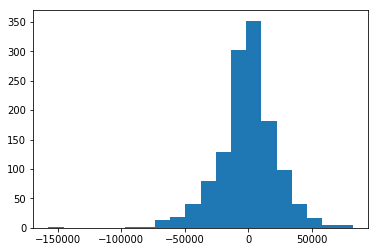

22959.918911110213

In [12]:
predictors = ['Country', 'Currency', 'YearsCodedJob']
res1 = regression(keep_columns(df, predictors))
res1.mse**0.5

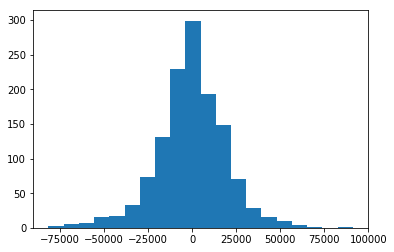

19548.879461642402

In [13]:
all_predictor_cols = [col for col in column_mapping.keys() if col != 'Salary']
res1 = regression(keep_columns(df, list(all_predictor_cols)))
res1.mse**0.5

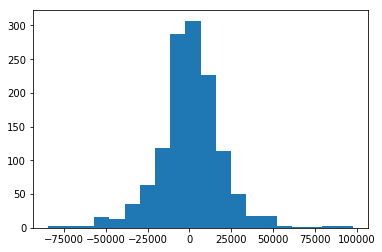

19304.2427499187

In [14]:
PCA = decomposition.PCA()
df_without_salary = df.drop(columns='Salary') 
PCA.fit(df_without_salary)
pca_ndarray = PCA.transform(df_without_salary)
pca_cols = ['PC{}'.format(i) for i in range(len(df_without_salary.columns))]
pca_df = pd.DataFrame(pca_ndarray, index=df.index, columns=pca_cols)
pca_df['Salary'] = df['Salary']
pca_reg = regression(pca_df)
pca_reg.mse**0.5

In [ ]:
pca_df.to_pickle('')

In [88]:
results_by_pc = {}
for principal_component in pca_df.drop(columns='Salary').columns:
    result = regression(pca_df[[principal_component, 'Salary']], plot=False)
    results_by_pc[principal_component] = result

In [89]:
most_correlated_pcs = sorted(results_by_pc.keys(), key=lambda pc: results_by_pc[pc].mse)

In [91]:
for principal_component in most_correlated_pcs:
    print('{}: {}'.format(principal_component, results_by_pc[principal_component].mse**0.5))

PC0: 34707.51324240157
PC743: 37283.20208720789
PC807: 37438.043598167606
PC528: 37582.34915258149
PC17: 37670.407717517635
PC364: 37687.743089248586
PC961: 37699.60827074003
PC706: 37700.96261388605
PC150: 37951.762621558446
PC598: 37970.67799401426
PC608: 37989.48879584811
PC133: 37993.628431564845
PC916: 38008.429037371614
PC302: 38029.17085466201
PC902: 38031.41532710535
PC827: 38067.989856278036
PC27: 38095.03736645521
PC804: 38114.16913841501
PC240: 38125.8331305941
PC966: 38132.80220167815
PC654: 38137.5483624402
PC181: 38139.9145553976
PC450: 38146.28129414538
PC639: 38147.0063237684
PC635: 38173.2340672725
PC12: 38202.776235648584
PC667: 38215.09955032956
PC643: 38230.151102815355
PC131: 38241.0429358212
PC943: 38255.32239732306
PC905: 38272.59159782449
PC441: 38278.13338305924
PC831: 38306.57335792004
PC443: 38346.67962884108
PC37: 38356.276226572394
PC941: 38365.79279105553
PC333: 38370.68936551019
PC157: 38371.03721772286
PC700: 38387.01270260344
PC31: 38400.34912542893
PC5

In [100]:
npcs = list(range(1, 984))
pca_mses = []
for npc in npcs:
    cols = most_correlated_pcs[:npc] + ['Salary']
    result = regression(pca_df[cols], plot=False)
    pca_mses.append(result.mse**0.5)
    if (npc % 50 == 0): print(npc)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


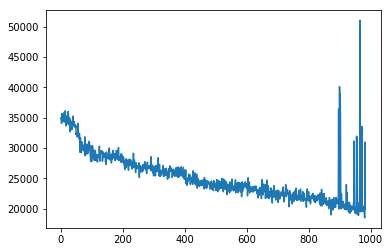

In [101]:
plt.plot(npcs, pca_mses)

In [107]:
pca_reg_results = pd.DataFrame({'NumPrincipalComponents':npcs, 'Mse':pca_mses}).set_index('NumPrincipalComponents')
pca_reg_results.to_csv('pca_reg_results.csv')

In [118]:
regression(pca_df, plot=False).mse**0.5

20118.306513608437